# W207 Final Project Notebook

In [1]:
#Well be using surprise package heavily as it features packages specifically for recommender systems
!pip install scikit-surprise

In [2]:
#Install recmetrics directly from Github repo
#in terminal by using: pip install git+https://github.com/statisticianinstilettos/recmetrics.git
import recmetrics

In [109]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

from IPython.display import display

from matplotlib.ticker import MultipleLocator

from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from datetime import datetime

import random
import warnings

import copy

# Set the randomizer seed so results are the same each time.
np.random.seed(0)
random.seed(0)
warnings.filterwarnings('ignore')

### Part 1: Load Dataset

In [4]:
%pwd

'/Users/jericojohns/Desktop/W207/W207_movies'

In [5]:
#Load data into ratings_df. 
ratings_df = pd.read_csv("/Users/jericojohns/Desktop/W207/data/ratings_small.csv", low_memory=False)

### Part 2: EDA

In [6]:
#Check structure. 
print(ratings_df.head())

#Check length. 
print(ratings_df.shape)

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
(100004, 4)


In [7]:
#Let's convert the timestamp to a more intuitive datetime
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], infer_datetime_format = True, yearfirst = True, unit = 's')

#And check our new dataframe
ratings_df

,userId,movieId,rating,timestamp,datetime
0,1,31,2.5,1260759144,2009-12-14 02:52:24
1,1,1029,3.0,1260759179,2009-12-14 02:52:59
2,1,1061,3.0,1260759182,2009-12-14 02:53:02
3,1,1129,2.0,1260759185,2009-12-14 02:53:05
4,1,1172,4.0,1260759205,2009-12-14 02:53:25
...,...,...,...,...,...
99999,671,6268,2.5,1065579370,2003-10-08 02:16:10
100000,671,6269,4.0,1065149201,2003-10-03 02:46:41
100001,671,6365,4.0,1070940363,2003-12-09 03:26:03
100002,671,6385,2.5,1070979663,2003-12-09 14:21:03


<AxesSubplot:>

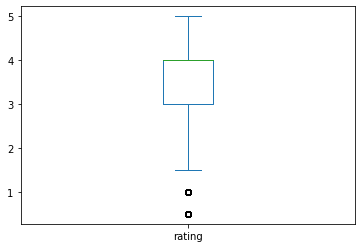

In [8]:
ratings_df[['rating']].plot.box()

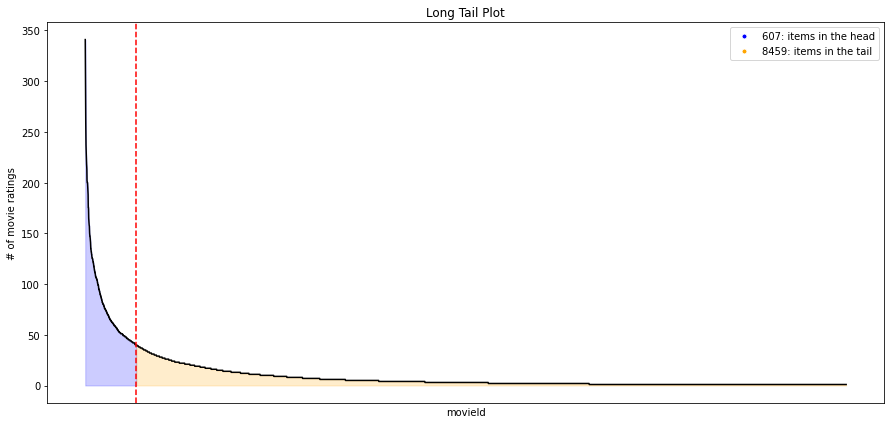

In [9]:
#Use recmetrics for Long Tail Plot Example of MovieID
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings_df, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

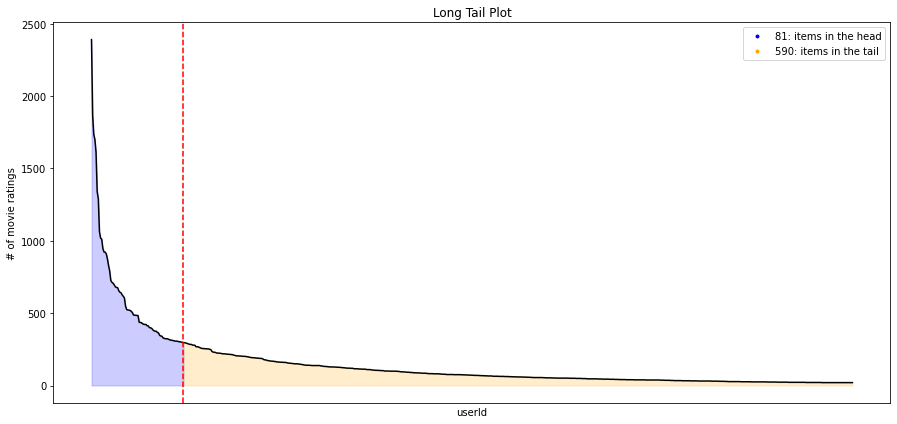

In [10]:
#Use recmetrics for Long Tail Plot Example of useriD
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings_df, 
             item_id_column="userId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

Ratings per User:


,rating
userId,
1,20
498,20
448,20
445,20
444,20
...,...
73,1610
15,1700
624,1735


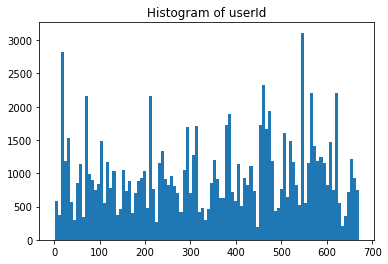

Ratings per Movie


,rating
movieId,
163949,1
26485,1
26480,1
26471,1
26467,1
...,...
260,291
593,304
318,311


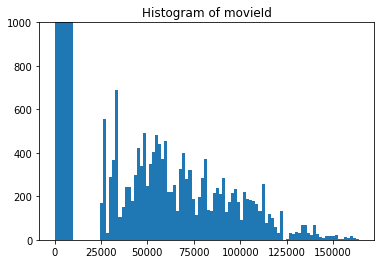

In [11]:
#Check number of ratings per user
print("Ratings per User:")
display(ratings_df[['userId','rating']].groupby('userId').count().sort_values(by = 'rating', ascending = True))


#Show histogram of number of ratings per user
plt.hist(ratings_df['userId'], bins = 100)
plt.title("Histogram of userId")
plt.show()

#Check number of ratings per movie
print("Ratings per Movie")
display(ratings_df[['movieId','rating']].groupby('movieId').count().sort_values(by = 'rating', ascending = True))

#Show histogram of number of ratings per movie
plt.hist(ratings_df['movieId'], bins = 100)
plt.ylim(0,1000)
plt.title("Histogram of movieId")
plt.show()

In [12]:
# Check how many users have 2 or more ratings
display(ratings_df[['userId','rating']].groupby('userId').count().sort_values(by = 'rating', ascending = True))

,rating
userId,
1,20
498,20
448,20
445,20
444,20
...,...
73,1610
15,1700
624,1735


<AxesSubplot:xlabel='datetime'>

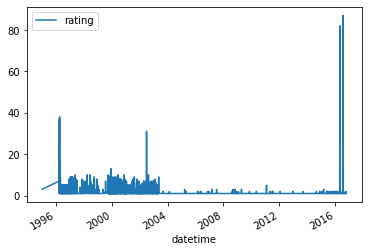

In [13]:
ratings_by_date = ratings_df[['datetime','rating']].groupby('datetime').count().sort_values(by = 'rating', ascending = True)

ratings_by_date.plot()

### Part 3: Baseline Collaborative Filtering Model

In [14]:
#Install recmetrics library for calculating diversity metrics 
#Source: https://github.com/statisticianinstilettos/recmetrics
!pip install recmetrics

In [125]:
#Load surprise packages which is a modified sklearn for recommender systems. 
from surprise import Reader
from surprise import SVD, SVDpp, NMF
from surprise import KNNBasic
from surprise import Dataset
from surprise import Trainset
from surprise import accuracy
from surprise.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from surprise.model_selection.search import GridSearchCV

from itertools import combinations

#Load recmetrics package
#import recmetrics.metrics

In [16]:
def filter_ratings(df, min_ratings):
    
    '''Filter users with num_ratings below min_ratings
    params: df, min_ratings
    return: sorted_filtered_df
    '''
    
    # Value counts of user ratings
    user_ratings_counts = df['userId'].value_counts()
    # List of users with ratings counts greater than min_ratings
    filtered_users = user_ratings_counts[user_ratings_counts >= min_ratings].index
    # Filter df to list of users above
    filtered_df = df[df['userId'].isin(filtered_users)]
    
    return filtered_df

In [17]:
def train_dev_test_split(ratings_df, dev_size=1, test_size=1):
    
    '''
    Split user ratings data into train, development and test sets holding the last 
    [test_size] ratings per user for test and last [dev_size] ratings per user for 
    development, following reverse chronological order
    
    Parameters
    ----------
    ratings_df : A dataframe of ratings data
    dev_size : The number of ratings per user to set asside development data
    test_size : The number of ratings per user to set asside test data
    
    Returns
    -------
    train_df : Dataframe of training ratings data
    dev_df : Dataframe of development ratings data
    test_df :  Dataframe of test ratings data
    '''
    
    # Add a column that ranks each rating in reverse chronolgical grouped by user
    ratings_df['rank'] = ratings_df.groupby(['userId'])['timestamp'] \
                         .rank(method='first', ascending=False).copy()
    
    # Filter to test data using rank column
    test_df = ratings_df[ratings_df['rank'].isin(range(1,1+test_size))][['userId', 'movieId', 'rating']]
    
    # Filter to dev data using rank column
    dev_df = ratings_df[ratings_df['rank'].isin(range(1+test_size, 1+test_size+dev_size))][['userId', 'movieId', 'rating']]
    
    # Filter to train data using rank column
    train_df = ratings_df[ratings_df['rank'] >= (1+test_size+dev_size)][['userId', 'movieId', 'rating']]
        
    return train_df, dev_df, test_df

In [18]:
def create_evaluation_pools(train_df, test_df, pool_size=100):
    
    '''
    Create pools of movies to evaluate the collaborative filtering models.
    Each pool will contain pool_size movies per user. Each pool includes the 
    movies in the test_df and randomly selects the rest of the movies from 
    those not watched by the user.
    
    Parameters
    ----------
    train_df : A dataframe of the training ratings data
    test_df : A dataframe of the test ratings data
    pool_size : The size of each movie pool
    
    Returns
    -------
    evaluation_pools_dict : A dictionary from user to the pool of movies on 
                            which to evaluate the recommender system
    
    '''
    
    # Find the list of unique users and movies in the training data
    users = set(train_df['userId'].unique())
    movies = set(train_df['movieId'].unique())
    
    # Instantiate the output dictionary
    evaluation_pools_dict = {}
    
    # Loop through each user
    for user in users:
        
        # Find set of movies rated by the user in the training and test data
        train_movies = set(train_df[train_df['userId']==user]['movieId'])
        test_movies = set(test_df[test_df['userId']==user]['movieId'])
        
        # Find the set of movies not rated by the user
        movies_not_rated = movies - train_movies - test_movies
        
        # Randomly sample movies from the movies not rated by the user
        n_movies_to_choose = pool_size - len(test_movies)
        sample_movies_not_rated = set(random.sample(movies_not_rated, n_movies_to_choose))
        
        # Combine the test movies with the random sample of movies
        evaluation_pool = list(test_movies | sample_movies_not_rated)
        
        # Add each evaluation_pool to the output dictionary 
        evaluation_pools_dict[user] = evaluation_pool
    
    return evaluation_pools_dict

In [78]:
def sort_evaluation_pools(model, evaluation_pools, ranking_list, ranking_movies):
    '''
    Take evaluation pool for each user and sort it based on ratings predicted by a 
    trained model in descending order of predicted ratings
    Parameters
    ----------
    model : A trained surprise model
    evaluation_pools : A dictionary from user to the pool of movies on 
                       which to evaluate the recommender system 
    ranking_list = movie novelty scores
    ranking_movies = movieIDs tied to novelty scores
    
    Returns
    -------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    '''
    
    # Instantiate output dictionary
    sorted_evaluation_pools = {}
    
    # Loop through each key-value pair in the input dictionary
    for user, movie_pool in evaluation_pools.items():
        
        # Create a dictionary for the predicted rating of each movie in the user's pool
        predictions = {}
        for movie in movie_pool:
            pred = model.predict(user, movie)
            novelty = ranking_list[ranking_movies.index(movie)]
            predictions[movie] = (pred[3],novelty)
            #Add in the novelty score
            
        
        # Sort the pool in descending order of predicted ratings
        sorted_pool = [(k,v) for k, v in sorted(predictions.items(), key=lambda item: item[1], reverse=True)]
        
        # Add key-value pair of user and sorted evalualtion pool to the output dictionary
        sorted_evaluation_pools[user] = sorted_pool
        
        #Finally reformat our dictionary to be in format userID: (movieID, rating, novelty)
        final_pool = defaultdict(list)
        for userID in sorted_evaluation_pools: 
            for movieID, tup in sorted_evaluation_pools[userID]: 
                final_pool[int(userID)].append((int(movieID), tup[0], tup[1]))


    return final_pool

In [20]:
def GetTopN(predictions, n=10, minimumRating=0.0):
    '''Get the top n predicted movie ratings for a given user.'''
    topN = defaultdict(list)
    for userID, movieID, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minimumRating):
            topN[int(userID)].append((int(movieID), estimatedRating))

    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(userID)] = ratings[:n]

    return topN

In [21]:
def HitRate(topNpredictions,leftoutpredictions):
    '''Take the most recent rating out of the training set to use in our test set, 
    and the second most recent to use in our dev set. If the top-n list of recommendations (predicted ratings)
    for a user contain the dev / test movie, we increase hit ratio by 1
    
    Source: https://medium.com/@rishabhbhatia315/recommendation-system-evaluation-metrics-3f6739288870''' 
    
    hits=0
    total=0
    for leftout in leftoutpredictions:
        userID = leftout[0]
        leftoutmovieId = leftout[1]
        hit = False
        for movieId ,predictedRating in topNpredictions[int(userID)]:
            if(int(movieId)==int(leftoutmovieId)):
                hit = True
        if(hit):
            hits+=1
        total+=1 
    
    return hits/total 

In [81]:
def calc_hit_rate_pools(sorted_evaluation_pools, test_df, top_n=10):
    '''
    Calculate hit rate given a dictionary of sorted evaluation pools and the corrsponding 
    test data frame. A hit is defined as finding a test movie in the top_n of sorted 
    evalutation pool of a user
    Parameters
    ----------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    test_df : A dataframe of ratings for movies being tested in the evaluation pools
    top_n : The threshold above which a test movies should be found to be called a hit
    
    Returns
    -------
    hit_rate : A hit rate across pools
    
    '''
    
    # Start with hits and totals at 0
    hits=0
    total=0
    
    # Loop through the each key-value pair in the input dictionary
    for user, sorted_pool in sorted_evaluation_pools.items():
        
        # Filter to test movies for the user
        test_movies = test_df[test_df['userId']==user]
        
        # Find top_n movies from the pool
        top_movies = sorted_pool[:top_n]
        
        # Loop through each test movie
        for index, test_movie in test_movies.iterrows():
            test_movie_id = test_movie['movieId']
            
            # If test movie is in top_movies, then add one to hits
            for movie, rating, novelty in top_movies: 
                if test_movie_id == movie:
                    hits += 1
                
            # Add one to total for each test movie  
            total += 1
     
    hit_rate = hits/total
    return hit_rate

In [82]:
def calc_hit_rate_pools_with_cutoff(sorted_evaluation_pools, test_df, top_n=10, rating_cutoff=0):
    '''
    Calculate hit rate given a dictionary of sorted evaluation pools and a corresponding 
    test data frame. A hit is defined as finding a test movie that has a rating greater 
    than a rating_cutoff in the top_n of sorted evalutation pool of a user.
    Parameters
    ----------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    test_df : A dataframe of ratings for movies being tested in the evaluation pools
    top_n : The threshold above which a test movies should be found to be called a hit
    rating_cutoff : The threshold rating above which a test movie should be evaluated
    
    Returns
    -------
    hit_rate : A hit rate across pools
    '''
    
    # Start with hits and totals at 0
    hits=0
    total=0
    
    # Loop through the each key-value pair in the input dictionary
    for user, sorted_pool in sorted_evaluation_pools.items():
        
        # Filter to test movies for the user
        test_movies = test_df[test_df['userId']==user]

         # Find top_n movies from the pool
        top_movies = sorted_pool[:top_n]
        
        # Loop through each test movie
        for index, test_movie in test_movies.iterrows():
            test_movie_rating = test_movie['rating']
            test_movie_id = test_movie['movieId']
            
             # If test movie has a rating above rating_cutoff then evaluate
            if test_movie_rating >= rating_cutoff:
                
                # If test movie is in top_movies, then add one to hits
                # If test movie is in top_movies, then add one to hits
                for movie, rating, novelty in top_movies: 
                    if test_movie_id == movie:
                        hits += 1
                
                # Add one to total for each test movie
                total += 1

    return hits/total

In [24]:
def HitRateAdjusted(topNpredictions,leftoutpredictions):
    '''Take the most recent rating out of the training set to use in our test set, 
    and the second most recent to use in our dev set. If the top-n list of recommendations (predicted ratings)
    for a user contain the dev / test movie, we increase hit ratio by 1 
    OR if the leftout movie is lower rated than the top n list (i.e. we correctly would not recommend to user) increase hit rate by 1.
    
    Source: https://medium.com/@rishabhbhatia315/recommendation-system-evaluation-metrics-3f6739288870''' 
    
    hits=0
    total=0
    for leftout in leftoutpredictions:
        userID = leftout[0]
        leftoutmovieId = leftout[1]
        leftoutrating = leftout[2]
        
        hit = False
        
        topNmovies = []
        topNRatings = []
        
        for movieId ,predictedRating in topNpredictions[int(userID)]:
            topNmovies.append(movieId)
            topNRatings.append(predictedRating)
        
        max_top_N_rating = max(topNRatings)
        min_top_N_rating = min(topNRatings)
        
        if leftoutrating < min_top_N_rating and leftoutmovieId not in topNmovies: 
            hit = True
        elif leftoutrating > min_top_N_rating and leftoutmovieId in topNmovies: 
            hit = True
        else: 
            hit = False
        
        if(hit):
            hits+=1
        total+=1 
    
    return hits/total 

In [25]:
def Diversity(topNPredicted, simsAlgo):
    '''where simsalgo = similarities.cosine() from surprise.'''
    n = 0
    total = 0
    simsMatrix = simsAlgo.compute_similarities()
    for userID in topNPredicted.keys():
        pairs = itertools.combinations(topNPredicted[userID], 2)
        for pair in pairs:
            movie1 = pair[0][0]
            movie2 = pair[1][0]
            innerID1 = simsAlgo.trainset.to_inner_iid(str(movie1))
            innerID2 = simsAlgo.trainset.to_inner_iid(str(movie2))
            similarity = simsMatrix[innerID1][innerID2]
            total += similarity
            n += 1
            
    S = total / n
    return (1-S)

In [26]:
def Novelty(topNPredicted, rankings):
    n = 0
    total = 0
    for userID in topNPredicted.keys():
        for rating in topNPredicted[userID]:
            movieID = rating[0]
            rank = rankings[movieID]
            total += rank
            n += 1
    return total / n

Good image to load in this spot: 
    https://www.google.com/url?sa=i&url=https%3A%2F%2Fstats.stackexchange.com%2Fquestions%2F390629%2Freference-point-in-projection-axis-of-svd-singular-value-decomposition&psig=AOvVaw1Lsj4Ue1mqmrwy-4FUoV7X&ust=1625783276443000&source=images&cd=vfe&ved=0CAoQjRxqFwoTCLDL7_GA0vECFQAAAAAdAAAAABA1   

### Implementation of our SVD Algorithm for Matrix Factorization based Collaborative Filtering: 

#### Normalize Movie Ratings by User. This way ratings are not impacted by "optimistic" and "pessimistic" reviewers. 
##### Normalized Rating = (Item_Rating - User_Avg_Rating) / User_Std_Dev. 

In [27]:
def custStandardScaler(train_df, dev_df, test_df): 
    '''Apply both StandardScaler and MinMaxScaler operations on our
    data, by user. Return both non-adjusted and adjusted dataframes.
    6 dataframes in total.'''
    

    #Rename columns
    train_df.columns = ["userId", "movieId","rating"]
    dev_df.columns = ["userId", "movieId","rating"]
    test_df.columns = ["userId", "movieId","rating"]

    #Calculate mean and std. for each user's ratings in the training data (i.e. fit on training data). 
    #Equivalent to StandardScaler in sklearn. 
    train_df['user_avg_ratings'] = train_df.groupby("userId")["rating"].transform('mean')
    train_df['user_std_dev'] = train_df.groupby("userId")["rating"].transform('std')
    train_df['std_rating'] = (train_df['rating'] - train_df['user_avg_ratings']) / train_df['user_std_dev']

    #Now apply to dev and test data
    dev_df['user_avg_ratings'] = train_df.groupby("userId")["rating"].transform('mean')
    dev_df['user_std_dev'] = train_df.groupby("userId")["rating"].transform('std')
    dev_df['std_rating'] = (dev_df['rating'] - train_df['user_avg_ratings']) / train_df['user_std_dev']

    test_df['user_avg_ratings'] = train_df.groupby("userId")["rating"].transform('mean')
    test_df['user_std_dev'] = train_df.groupby("userId")["rating"].transform('std')
    test_df['std_rating'] = (test_df['rating'] - train_df['user_avg_ratings']) / train_df['user_std_dev']

    #Now we must scale the data to get back to ratings between 0 and 5. 
    #Equivalent of MinMaxScaler() in sklearn. 
    train_df['min_std_rating'] = train_df.groupby("userId")["std_rating"].transform('min')
    train_df['max_std_rating'] = train_df.groupby("userId")["std_rating"].transform('max')
    train_df['std_sc_rating'] = ((train_df['std_rating'] - train_df['min_std_rating']) / (train_df['max_std_rating']- train_df['min_std_rating'])) * 5

    #Now apply to dev and test data
    dev_df['min_std_rating'] = train_df.groupby("userId")["std_rating"].transform('min')
    dev_df['max_std_rating'] = train_df.groupby("userId")["std_rating"].transform('max')
    dev_df['std_sc_rating'] = ((dev_df['std_rating'] - train_df['min_std_rating']) / (train_df['max_std_rating']- train_df['min_std_rating'])) * 5

    test_df['min_std_rating'] = train_df.groupby("userId")["std_rating"].transform('min')
    test_df['max_std_rating'] = train_df.groupby("userId")["std_rating"].transform('max')
    test_df['std_sc_rating'] = ((test_df['std_rating'] - train_df['min_std_rating']) / (train_df['max_std_rating']- train_df['min_std_rating'])) * 5

    #Finally we return the raw and adjusted ratings as two different df objects
    train_df_abs = train_df[['userId','movieId','rating']]
    dev_df_abs = dev_df[['userId','movieId','rating']]
    test_df_abs = test_df[['userId','movieId','rating']]

    
    train_df_sc = train_df[['userId','movieId','std_sc_rating']]
    dev_df_sc = dev_df[['userId','movieId','std_sc_rating']]
    test_df_sc = test_df[['userId','movieId','std_sc_rating']]
    
    #Rename rating column so that all dataframes are consistent. 
    train_df_sc.columns = ["userId", "movieId","rating"]
    dev_df_sc.columns = ["userId", "movieId","rating"]
    test_df_sc.columns = ["userId", "movieId","rating"]
    
    return train_df_abs, dev_df_abs, test_df_abs, train_df_sc, dev_df_sc, test_df_sc

#### Train, Val, Test Splits for both Unadjusted and Adjusted Ratings

In [29]:
#Filter our user list to those users who have 30+ ratings
filtered_data = filter_ratings(ratings_df, min_ratings = 30)

#Now split our data so that we take the n-1 (most recent) rating as our test rating, 
#and n-2 (second most recent) rating as our dev rating 
train_df, dev_df, test_df = train_dev_test_split(filtered_data)

dev_evaluation_pools = create_evaluation_pools(train_df, dev_df)

#Create a surprise Reader object to help us create a Surprise DataSet object. 
reader = Reader()

#Now we load training data as is (no folding) by calling the .build_full_trainset() method. 
train_data = Dataset.load_from_df(train_df, reader).build_full_trainset()


#Convert dev_data to DataSet object, and then as testset object by calling .buildtestset()
dev_data = Dataset.load_from_df(dev_df, reader).build_full_trainset()
dev_data = dev_data.build_testset()

#Convert test_data to DataSet object, and then as testset object by calling .buildtestset()
test_data = Dataset.load_from_df(test_df, reader).build_full_trainset()
test_data = test_data.build_testset()

#### Train and Test Baseline Model

##### First compare our adjusted and unadjusted ratings performance to
##### ensure we can move forward with the normalized and scaled ratings. 

#### Item Based Diversity Calculations

1.) Novelty scaled from 0,5

In [152]:
#Create a dictionary of rating counts for movies
rankings = ratings_df["movieId"].value_counts()

#Let's standardize our rankings to be able to be used together 
scaler = MinMaxScaler(feature_range = (0,5))
ranking_movieID = rankings.index.to_numpy()

sc_rankings = rankings.to_numpy().reshape(-1,1)
sc_rankings = scaler.fit_transform(sc_rankings)

sc_rankings = sc_rankings.tolist()

#TODO: Check that this adjustment makes sense and keeps ranking meaning 
#Since ranking is actually just a movieID count in the dataset, we need to inverse the value
#by multiplying by -1, and then renormalize to 0,5 scale by adding 5. So that least popular movies
#have rating close to 5 and most popular movies have ratings close to 0. 
sc_rankings = [(float(i[0])*-1)+5 for i in sc_rankings]

ranking_movieID = ranking_movieID.tolist()

2.) Novelty scaled on same distribution as ratings (to use with blended swap logic) 

In [176]:
#Create a dictionary of rating counts for movies
rankings = ratings_df["movieId"].value_counts()
ratings =  ratings_df[['movieId','rating']].groupby('movieId').mean()

#Let's standardize our rankings to be able to be used together 
scaler = MinMaxScaler(feature_range = (0,5))
scaler2 = RobustScaler()
ranking_movieID = rankings.index.to_numpy()
ratings = ratings.to_numpy().reshape(-1,1)

scaler.fit(ratings)
scaler2.fit(ratings)
sc_rankings = rankings.to_numpy().reshape(-1,1)
sc_rankings = scaler2.transform(sc_rankings)
sc_rankings = scaler.fit_transform(sc_rankings)



sc_rankings = sc_rankings.tolist()

sc_rankings = [(float(i[0])*-1)+5 for i in sc_rankings]


ranking_movieID = ranking_movieID.tolist()

(array([3.00e+00, 3.00e+00, 3.00e+00, 1.10e+01, 2.00e+01, 2.50e+01,
        7.80e+01, 1.29e+02, 4.24e+02, 8.37e+03]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

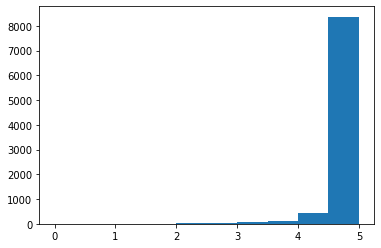

In [228]:
plt.hist(sc_rankings)

(array([ 105.,  208.,  267.,  583.,  848., 1644., 2003., 2261.,  785.,
         362.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

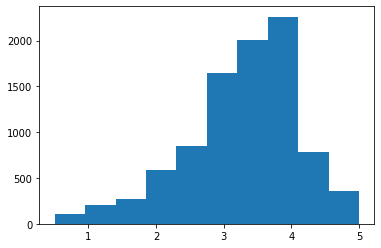

In [229]:
plt.hist(ratings)

3.) Novelty adjusted by days the movie has existed for ratings (i.e. movies that have been around longer get hurt by having more ratings). 

In [230]:
#Train and test algorithm (Matrix Factorization for Collaborative Filtering)

#Train and test algorithm (Matrix Factorization for Collaborative Filtering)
algo = SVD()

#Train our train_data (all user's that have liked 30+ movies, train on the n-2 movie set)
algo.fit(train_data)

# Sort dev evaluation pools based on SVD model
sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools, sc_rankings, ranking_movieID)

#Set our n value for how how many top predicted movies we'll test against
n = 10
rating_cutoff = 4

#hit_rate = HitRate(topNPredicted, leftoutpredictions)
hit_rate_pools = calc_hit_rate_pools(sorted_dev_evaluation_pools, dev_df)
hit_rate_pools_with_cutoff = calc_hit_rate_pools_with_cutoff(sorted_dev_evaluation_pools, dev_df, rating_cutoff=4)

#Print Summary
print(f'HR@10 for random pools and n = {n}: {hit_rate_pools:.3f}')
print(f'Cumulative HR@10 for random pools > {rating_cutoff} and n = {n}: {hit_rate_pools_with_cutoff:.3f}')

HR@10 for random pools and n = 10: 0.322
Cumulative HR@10 for random pools > 4 and n = 10: 0.434


#### Function to Evaluate the different surprise models to select the best baseline model for HR@10. 

In [231]:
def compareModels(models, train_data, dev_data): 
    for algo in models: 
        #Print model type 
        print(type(algo).__name__)
        
        #Train our train_data (all user's that have liked 30+ movies, train on the n-2 movie set)
        algo.fit(train_data)
        
        #Sort our evaluation pool, using the algo. 
        sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools)

        #Set our n value for how how many top predicted movies we'll test against and rating cutoff. 
        n = 10
        ratingCutoff = 4
        
        #Calculate the two hit rates
        hit_rate_pools = calc_hit_rate_pools(sorted_dev_evaluation_pools, dev_df)
        hit_rate_pools_with_cutoff = calc_hit_rate_pools_with_cutoff(sorted_dev_evaluation_pools, dev_df, rating_cutoff=4)

        print(f'HR@10 for random pools and n = {n}: {hit_rate_pools:.3f}')
        print(f'Cumulative HR@10 for random pools > {ratingCutoff} and n = {n}: {hit_rate_pools_with_cutoff:.3f}')

In [65]:
#Compare the matrix factorization models from Surprise to pick the baseline model that optimizes HR@10 
models = [SVD(), SVDpp(), NMF()]
compareModels(models, train_data, dev_df)

SVD
HR@10 for random pools and n = 10: 0.336
Cumulative HR@10 for random pools > 4 and n = 10: 0.437
SVDpp
HR@10 for random pools and n = 10: 0.315
Cumulative HR@10 for random pools > 4 and n = 10: 0.386
NMF
HR@10 for random pools and n = 10: 0.145
Cumulative HR@10 for random pools > 4 and n = 10: 0.177


#### Now finetune the best baseline model using our own param passes. 
##### This is necessary because GridSearchCV uses Surprise's own train/dev split methods and accuracy scores. This would create spillover. 

In [69]:
#To optimize: 
#Note default values n_factors = 100, n_epochs = 20, lr_all = 0.005, reg_all = 0.02
n_factors = [50, 100, 200, 500]
n_epochs = [10,20,30]
lr_all = [0.001, 0.005, 0.01]
reg_all = [0, 0.01, 0.02, 0.04]

best_hr = 0
best_n_factors = 0
best_n_epochs = 0 
best_lr_all = 0 
best_reg_all = 0

for n_factor in n_factors: 
    for n_epoch in n_epochs: 
        for lr in lr_all: 
            for reg in reg_all: 
                algo = SVD(n_factors = n_factor, n_epochs = n_epoch, lr_all = lr, reg_all = reg)
                algo.fit(train_data)
                sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools)
                #Set our n value for how how many top predicted movies we'll test against and rating cutoff. 
                n = 10
                ratingCutoff = 4

                #Calculate the two hit rates
                hit_rate_pools = calc_hit_rate_pools(sorted_dev_evaluation_pools, dev_df)
                hit_rate_pools_with_cutoff = calc_hit_rate_pools_with_cutoff(sorted_dev_evaluation_pools, dev_df, rating_cutoff=4)
                #print(f'n_factors = {n_factor}, n_epochs = {n_epoch}, lr_all = {lr}, reg_all = {reg}')
                #print(f'HR@10 for random pools and n = {n}: {hit_rate_pools:.3f}')
                #print(f'Cumulative HR@10 for random pools > {ratingCutoff} and n = {n}: {hit_rate_pools_with_cutoff:.3f}')
                
                if hit_rate_pools > best_hr: 
                    best_hr = hit_rate_pools
                    best_n_factors = n_factor
                    best_n_epochs = n_epoch
                    best_lr_all = lr
                    best_reg_all = reg
                    
                    
print(f'Best HR@10: {best_hr}')
print(f'n_factors = {best_n_factors}, n_epochs = {best_n_epochs}, lr_all = {best_lr_all}, reg_all = {best_reg_all}')
                
                

Best HR@10: 0.38517179023508136
n_factors = 50, n_epochs = 30, lr_all = 0.001, reg_all = 0


#### Create a dictionary of "rankings" (number of ratings in dataset, which will be our popularity measure). 

##### Scale our rankings (popularity) to be on same scale as ratings (0,5) using min_max scaler. 

#### Add Diversity Into Optimization Problem (Modified Cost Function)

In [29]:
#Pull top-10 predicted ratings + rankings. This is our new ordered list. 
# def GetTopNBlended(predictions, ranking_list, ranking_movies, n=10, minimumRating=0.0, w1 = 0.5, w2 = 0.5):
#     '''Get the top n predicted movie ratings for a given user.'''
#     topN = defaultdict(list)
#     remainingN = defaultdict(list)
    
#     for userID, movieID, actualRating, estimatedRating, _ in predictions:
#         if (estimatedRating >= minimumRating):
            
#             #Adjustment to solve for novelty within equation
#             noveltyRanking = ranking_list[ranking_movies.index(movieID)]
            
#             estBlendedRating = (w1 * estimatedRating) + (w2 * noveltyRanking)
            
#             topN[int(userID)].append((int(movieID), estBlendedRating))
            
#     for userID, ratings in topN.items():
#         ratings.sort(key=lambda x: x[1], reverse=True)
#         topN[int(userID)] = ratings[:n]
#         #Pull the next n items as the remainingN list 
#         remainingN[int(userID)] = ratings[n:(n+n)]

#     return topN, remainingN

#### Split and Swap Method of Diverifying List. 
##### Inspiration: http://ceur-ws.org/Vol-1181/pia2014_paper_02.pdf
##### Note: Current implementation is solely based on increasing novelty. Can update to swap based on blended rating & novelty. 

In [62]:
#Create a topN list and remainingN list, to use with diversity swapping method. 
def GetTopNSplitPools(sorted_evaluation_pool, n):
    '''Get the top n predicted movie ratings for a given user.'''
    predictions = sorted_evaluation_pool
    topN = defaultdict(list)
    nextN = defaultdict(list)
    remainingN = defaultdict(list)
    
    #Select top_n and remaining_n
    for userID, movies in predictions.items():
        topN[int(userID)] = movies[:n]
        #Pull the next n items as the remainingN list 
        nextN[int(userID)] = movies[n:(n+n)]
        remainingN[int(userID)] = movies[(n+n):]
        

    return topN, nextN, remainingN

In [232]:
#Return the first 10 movies (in predicted rating) from the evaluation_pool, 
#and then the remaining n. We will use this structure to swap our predictions for diversity. 
algo = SVD()
algo.fit(train_data)
sorted_dev_evaluation_pool = sort_evaluation_pools(algo, dev_evaluation_pools,sc_rankings, ranking_movieID)

#Need to pass algo so that we can build the proper dictionary with predictions
topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split = GetTopNSplitPools(sorted_dev_evaluation_pool, n = 20)

In [243]:
def diversificationSwap(topNPredicted, nextNPredicted, remainingNPredicted, iterations = 1): 
    '''For iteration in desired number of iterations (hyperparam): 
    drop the lowest novelty item from the topN list and
    replace with the highest novelty item from the remainingN list.'''
    
    
    topNPredicted_temp = copy.deepcopy(topNPredicted)
    nextNPredicted_temp = copy.deepcopy(nextNPredicted)
    
    for i in range(iterations): 
        for userID in topNPredicted_temp.keys():
            #Create a boolean that indicates whether swap is found
            swap_top = False
            
            #Drop items from topN and add to remainingN
            min_ranking = 5 
            min_movieID = None
            min_rating = None
            
            for item in topNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                
                if rank < min_ranking: 
                    swap_top = True
                    min_ranking = rank
                    min_movieID = movieID
                    min_rating = rating
                    
                    
            #Now shuffle (only if swap is found)
            if swap_top == True: 
                nextNPredicted_temp[int(userID)].append((int(min_movieID), min_rating, min_ranking))
                topNPredicted_temp[int(userID)].remove((int(min_movieID), min_rating, min_ranking))
            
            #Create a boolean that indicates whether swap is found
            swap_bottom  = False
            
            #Add items to topN and drop from remainingN
            max_ranking = 0 
            max_movieID = None
            max_rating = None
            
            for item in nextNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                
                if rank > max_ranking: 
                    swap_bottom = True
                    max_ranking = rank
                    max_movieID = movieID
                    max_rating = rating
                    
            #Now shuffle (only if swap is found)
            if swap_bottom == True: 
                topNPredicted_temp[int(userID)].append((int(max_movieID), max_rating, max_ranking))
                nextNPredicted_temp[int(userID)].remove((int(max_movieID), max_rating, max_ranking))
    
    #Now drop the ranking as this isn't needed for hit rate calcs. 
    #topNPredicted_temp.update(item[:-1] for item in value[items] for value in topNPredicted_temp.values())
    #remainingNPredicted_temp.update(item[:-1] for item in value[items] for value in remainingNPredicted.values())
    final_sorted_pool = defaultdict(list)
    
    #Add the top predicted, diversified items to our final evaluation_pool
    for userID in topNPredicted_temp.keys(): 
        for item in topNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the next N 
    for userID in nextNPredicted_temp.keys(): 
        for item in nextNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the remaining (unswapped) N items to create the full diversified evaluation pool 
    for userID in remainingNPredicted.keys(): 
        for item in remainingNPredicted[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
        
    return final_sorted_pool
        

In [254]:
def diversificationSwapBlended(topNPredicted, nextNPredicted, remainingNPredicted, iterations = 1, w1 = 0.5, w2 = 0.5): 
    '''For iteration in desired number of iterations (hyperparam): 
    drop the lowest blended rating and novelty item from the topN list and
    replace with the highest blended rating and novelty item from the remainingN list.
    This methods approximate's a movie's 'Hidden Gem' score (i..e high rating, low ranking)'''
    
    
    topNPredicted_temp = copy.deepcopy(topNPredicted)
    nextNPredicted_temp = copy.deepcopy(nextNPredicted)
    
    for i in range(iterations): 
        for userID in topNPredicted_temp.keys():
            #Create a boolean that indicates whether swap is found
            swap_top = False
            
            #Drop items from topN and add to remainingN
            min_blended_rank = 5
            min_movieID = None
            min_rating = None
            
            for item in topNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                blended_rank = (w1*rating) + (w2*rank)
                
                if blended_rank < min_blended_rank: 
                    swap_top = True
                    min_blended_rank = blended_rank
                    min_movieID = movieID
                    min_ranking = rank
                    min_rating = rating
                    
                    
            #Now shuffle (only if swap is found)
            if swap_top == True: 
                nextNPredicted_temp[int(userID)].append((int(min_movieID), min_rating, min_ranking))
                topNPredicted_temp[int(userID)].remove((int(min_movieID), min_rating, min_ranking))
            
            #Create a boolean that indicates whether swap is found
            swap_bottom  = False
            
            #Add items to topN and drop from remainingN
            max_blended_rank = 0 
            max_movieID = None
            max_rating = None
            
            for item in nextNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                blended_rank = (w1*rating) + (w2*rank)
                
                if blended_rank > max_blended_rank: 
                    swap_bottom = True
                    max_blended_rank = blended_rank
                    max_ranking = rank
                    max_movieID = movieID
                    max_rating = rating
                    
            #Now shuffle (only if swap is found)
            if swap_bottom == True: 
                topNPredicted_temp[int(userID)].append((int(max_movieID), max_rating, max_ranking))
                nextNPredicted_temp[int(userID)].remove((int(max_movieID), max_rating, max_ranking))
    
    #Now drop the ranking as this isn't needed for hit rate calcs. 
    #topNPredicted_temp.update(item[:-1] for item in value[items] for value in topNPredicted_temp.values())
    #remainingNPredicted_temp.update(item[:-1] for item in value[items] for value in remainingNPredicted.values())
    final_sorted_pool = defaultdict(list)
    
    #Add the top predicted, diversified items to our final evaluation_pool
    for userID in topNPredicted_temp.keys(): 
        for item in topNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the next N 
    for userID in nextNPredicted_temp.keys(): 
        for item in nextNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the remaining (unswapped) N items to create the full diversified evaluation pool 
    for userID in remainingNPredicted.keys(): 
        for item in remainingNPredicted[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
        
    return final_sorted_pool
        

In [248]:
diversified_evaluation_pools = diversificationSwap(topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split, iterations = 2)

In [249]:
#Calculate diversified hit rate
hit_rate_diversified_pools = calc_hit_rate_pools(diversified_evaluation_pools, dev_df)
hit_rate_diversified_pools_with_cutoff =  calc_hit_rate_pools_with_cutoff(diversified_evaluation_pools, dev_df, rating_cutoff=4)
print(f'HR@10 for random pools and n = 10: {hit_rate_diversified_pools:.3f}')
print(f'Cumulative HR@10 for random pools > 4 and n = 10: {hit_rate_diversified_pools_with_cutoff:.3f}')

HR@10 for random pools and n = 10: 0.156
Cumulative HR@10 for random pools > 4 and n = 10: 0.158


In [160]:
#Calculate average novelty, average rating, and hit rate for the top 10 of final sorted_evaluation_pool. 

def summaryStats(diversified_evaluation_pools, test_df, rating_cutoff = None): 
    hit_rate_diversified_pools = calc_hit_rate_pools(diversified_evaluation_pools, test_df)
    hit_rate_diversified_pools_with_cutoff =  calc_hit_rate_pools_with_cutoff(diversified_evaluation_pools, dev_df, rating_cutoff=rating_cutoff)
    
    total_est_rating = 0 
    total_novelty = 0 
    total_items = 0 
    for userID in diversified_evaluation_pools.keys(): 
        for tup in diversified_evaluation_pools[userID][:10]: 
            total_est_rating += tup[1]
            total_novelty += tup[2]
            total_items += 1
    
    avg_est_rating  = total_est_rating / total_items
    avg_novelty = total_novelty / total_items
    
    return hit_rate_diversified_pools, hit_rate_diversified_pools_with_cutoff, avg_est_rating, avg_novelty 
        


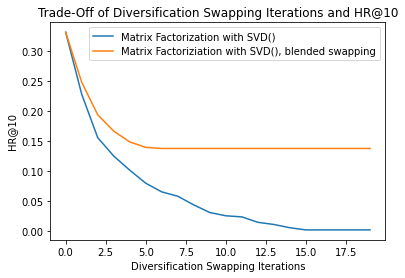

In [279]:
#Plot our novelty / HR@10 tradeoff by increasing number of iterations of our dviersificationSwap. 
method = []
average_novelty = [] 
hit_rate = [] 

method_blended = []
average_novelty_blended = []
hit_rate_blended = []

hit_rate_cutoff = []
hit_rate_cutoff_blended = [] 

swapping_iterations = []
swapping_iterations_blended = []

for i in range(0,20): 
    diversified_evaluation_pools = diversificationSwap(topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split, iterations = i)
    diversified_evaluation_pools_blended = diversificationSwapBlended(topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split, iterations = i, w1 = 0.7, w2 = 0.3)
    hit_rate_diversified_pools, hit_rate_diversified_pools_with_cutoff, avg_est_rating, avg_novelty = summaryStats(diversified_evaluation_pools, dev_df, rating_cutoff = 4)
    hit_rate_diversified_pools_blended, hit_rate_diversified_pools_with_cutoff_blended, avg_est_rating_blended, avg_novelty_blended = summaryStats(diversified_evaluation_pools_blended, dev_df, rating_cutoff = 4)
    model = 'Matrix Factorization with SVD()'
    blended_model = 'Matrix Factoriziation with SVD(), blended swapping'
    
    method.append(model)
    method_blended.append(model)
    
    average_novelty.append(avg_novelty)
    average_novelty_blended.append(avg_novelty_blended)
    
    swapping_iterations.append(i)
    swapping_iterations_blended.append(i)
    
    hit_rate.append(hit_rate_diversified_pools)
    hit_rate_blended.append(hit_rate_diversified_pools_blended)
    
    hit_rate_cutoff.append(hit_rate_diversified_pools_with_cutoff)
    hit_rate_cutoff_blended.append(hit_rate_diversified_pools_with_cutoff_blended)


plt.plot(swapping_iterations, hit_rate, label = 'Matrix Factorization with SVD()')
plt.plot(swapping_iterations_blended, hit_rate_blended, label = 'Matrix Factoriziation with SVD(), blended swapping')
plt.title("Trade-Off of Diversification Swapping Iterations and HR@10")
plt.xlabel("Diversification Swapping Iterations")
plt.ylabel("HR@10")
plt.legend(loc = 'best')

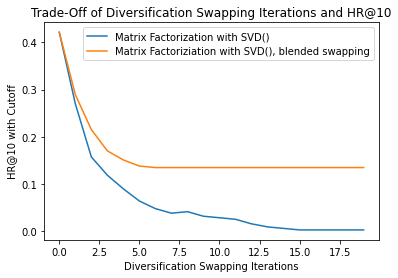

In [280]:
plt.plot(swapping_iterations, hit_rate_cutoff, label = 'Matrix Factorization with SVD()')
plt.plot(swapping_iterations_blended, hit_rate_cutoff_blended, label = 'Matrix Factoriziation with SVD(), blended swapping')
plt.title("Trade-Off of Diversification Swapping Iterations and HR@10")
plt.xlabel("Diversification Swapping Iterations")
plt.ylabel("HR@10 with Cutoff")
plt.legend(loc = 'best')

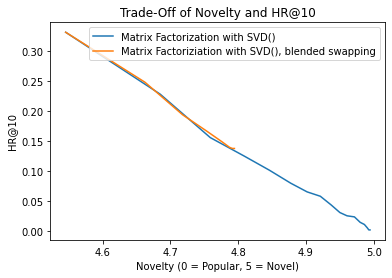

In [264]:
plt.plot(average_novelty, hit_rate, label = 'Matrix Factorization with SVD()')
plt.plot(average_novelty_blended, hit_rate_blended, label = 'Matrix Factoriziation with SVD(), blended swapping')
plt.title("Trade-Off of Novelty and HR@10")
plt.xlabel("Novelty (0 = Popular, 5 = Novel)")
plt.ylabel("HR@10")
plt.legend(loc = 'best')

#### Create a Random Recommender and Popular Movie Recommender as comparison points to our algo. 

#### Compare performance of different models. 

In [276]:
def sort_evaluation_pools_Random(model, evaluation_pools, ranking_list, ranking_movies):
    '''
    Take evaluation pool for each user and sort it randomly. 
    Parameters
    ----------
    model : A trained surprise model
    evaluation_pools : A dictionary from user to the pool of movies on 
                       which to evaluate the recommender system 
    ranking_list = movie novelty scores
    ranking_movies = movieIDs tied to novelty scores
    
    Returns
    -------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    '''
    
    # Instantiate output dictionary
    sorted_evaluation_pools = {}
    
    # Loop through each key-value pair in the input dictionary
    for user, movie_pool in evaluation_pools.items():
        
        # Create a dictionary for the predicted rating of each movie in the user's pool
        predictions = {}
        for movie in movie_pool:
            pred = model.predict(user, movie)
            novelty = ranking_list[ranking_movies.index(movie)]
            predictions[movie] = (pred[3],novelty)
            #Add in the novelty score
            
        
        # Sort the pool in descending order of predicted ratings
        sorted_pool = [(k,v) for k, v in random.shuffle(list(predictions.items()))]
        
        # Add key-value pair of user and sorted evalualtion pool to the output dictionary
        sorted_evaluation_pools[user] = sorted_pool
        
        #Finally reformat our dictionary to be in format userID: (movieID, rating, novelty)
        final_pool = defaultdict(list)
        for userID in sorted_evaluation_pools: 
            for movieID, tup in sorted_evaluation_pools[userID]: 
                final_pool[int(userID)].append((int(movieID), tup[0], tup[1]))


    return final_pool

In [277]:
random_pools = sort_evaluation_pools_Random(algo, dev_evaluation_pools, sc_rankings, ranking_movieID)

TypeError: 'NoneType' object is not iterable

## DNU
##### General Optimization Problem for use with different diversity metrics. 

In [36]:
#Compute top 10 recs for each user using our defined topNPredicted Function above
topNPredicted = GetTopN(allPredictions, n=10)

In [37]:
#Note: w1 = weight * rating, w2 = weight * ranking (novelty)

topNPredicted_Blended, remainingNPredicted = GetTopNBlended(allPredictions, sc_rankings, ranking_movieID, n=10, w1 = 0.9, w2 = 0.1)

KeyboardInterrupt: 

In [ ]:
#Select the 10 most popular (i.e. least novel) movies from the predictions list for each user. 
topNPredicted_Popular = GetTopNPopular(allPredictions, sc_rankings, ranking_movieID, n = 10)

In [ ]:
#Randomly select 10 movie recs for each user. 
topNPredicted_Random = GetTopNRandom(allPredictions, n=10)

In [ ]:
#COMPARE MODELS 
#Calculate our evaluation metrics of interest
hit_rate = HitRate(topNPredicted, leftoutpredictions)
hit_rate_Blended = HitRate(topNPredicted_Blended, leftoutpredictions)
hit_rate_Swapped = HitRate(topNPredicted_Split_Swapped, leftoutpredictions)
hit_rate_Random = HitRate(topNPredicted_Random, leftoutpredictions)
hit_rate_Popular = HitRate(topNPredicted_Popular, leftoutpredictions)
# adjusted_hit_rate = HitRateAdjusted(topNPredicted, leftoutpredictions)
# adjusted_hit_rate_Blended = HitRateAdjusted(topNPredicted_Blended, leftoutpredictions)
#rmse = accuracy.rmse(leftoutpredictions, verbose = False)
#Print our evaluation metrics of interest
print(f'Standard: Hit Rate for n = {n}: {hit_rate:.4f}')
print(f'Blended: Hit Rate for n = {n}: {hit_rate_Blended:.4f}')
print(f'Swapped: Hit Rate for n = {n}: {hit_rate_Swapped:.4f}')
print(f'Random: Hit Rate for n = {n}: {hit_rate_Random:.4f}')
print(f'Popular: Hit Rate for n = {n}: {hit_rate_Popular:.4f}')
# print(f'Adjusted Hit Rate for n = {n}: {adjusted_hit_rate:.3f}')
# print(f'Blended, Adjusted Hit Rate for n = {n}: {adjusted_hit_rate_Blended:.3f}')

In [34]:
#Random Recommender System
def GetTopNRandom(predictions, n=10, minimumRating=0.0):
    '''Get the top n predicted movie ratings for a given user.'''
    topN = defaultdict(list)
    for userID, movieID, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minimumRating):
            topN[int(userID)].append((int(movieID), estimatedRating))

    for userID, ratings in topN.items():
        random.shuffle(ratings)
        topN[int(userID)] = ratings[:n]

    return topN

In [35]:
#Popular Recommender System
def GetTopNPopular(predictions, ranking_list, ranking_movies, n=10, minimumRating=0.0):
    '''Get the top n predicted movie ratings for a given user.'''
    topN = defaultdict(list)
    
    for userID, movieID, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minimumRating):
            
            #Adjustment to solve for novelty within equation
            noveltyRanking = ranking_list[ranking_movies.index(movieID)]
            
            popularity_rating = noveltyRanking
            
            topN[int(userID)].append((int(movieID), popularity_rating))
            
    for userID, ratings in topN.items():
        #Select the least novel (i.e. most popular) movies
        ratings.sort(key=lambda x: x[1], reverse=False)
        topN[int(userID)] = ratings[:n]

    return topN

In [ ]:
#Create list of user's movieID's, movie rankings (for novelty), and movie estimated rating 
%load_ext autotime

w1 = 0.5 
w2 = 1 - w1 

blendedtopN = defaultdict(list)

best_combo = ()

for userID in list(topNPredicted.keys())[:1]:
    user_list = [] 
    movie_list = []
    rank_list = []
    rating_list = [] 
    
    best_score = 0 
    
    for rating in topNPredicted[userID]: 
        user_list.append(userID)
        movie_list.append(rating[0])
        rank_list.append(rankings[rating[0]])
        rating_list.append(rating[1])
    
    
    
    for combo in combinations(movie_list, 10): 
        #Initialize running sums to zero
        rating_sum = 0 
        novelty_sum = 0
        
        for movie in combo: 
            idx = movie_list.index(movie)
            rating_sum += rating_list[idx]
            novelty_sum += rank_list[idx]
            
        blended_score = (w1*rating_sum) + (w2*novelty_sum)
        
        if blended_score > best_score: 
            best_combo = combo 
            best_score = blended_score
        
    print(f'User ID: {userID}, Best Combo: {best_combo}, Best Score: {best_score}')
            
            
            
            
# print(user_list)
# print(movie_list)
# print(rank_list)
# print(rating_list)

We are pulling the SVD initialization (below) from Surprise code directly to create our modified SVD class: 
https://github.com/NicolasHug/Surprise/blob/master/surprise/prediction_algorithms/matrix_factorization.pyx

In [ ]:
#NOT USED

#https://realpython.com/python-scipy-cluster-optimize/#using-the-optimize-module-in-scipy

#Pull top 100 predicted movies, then select top 10 movie rating + novelty from this constrained list
def objective_function(topNPredicted, rankings): 
    for userID in topNPredicted.keys(): 
        for rating in topNPredicted[userID]: 
            movieID = rating[0]
            est_rating = rating[1]
            rank = rankings[movieID]
            
            
            
            
    
    
    

Notes: 
- Might help to break out the adjusted hit rate by the positive hit rate and negative hit rate (in list, vs lower ranked than top n list and not in list, vs higher ranked than top n list and not in list). 
